# Understanding cloud organization with MaskRCNN using Keras/Tensorflow

This kernel is a first attempt to use a MaskRCNN to solve the cloud organization classification problem. It also helps to evaluate how promising the results are within the allowed processing time on kernels as it is likely such model will take much longer to train properly. It is using the [Matterplot implementation of MaskRCNN](https://github.com/matterport/Mask_RCNN) and is inspired from [this kernel](https://www.kaggle.com/pednoi/training-mask-r-cnn-to-be-a-fashionista-lb-0-07) from the iMaterialist competition. 


In [1]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import itertools
from tqdm import tqdm

In [2]:
if(os.getcwd() == '/kaggle/working/Mask_RCNN'): #go up a level (just in case cells were executed out of order)
    os.chdir('../')


train_df = pd.read_csv("../input/understanding_cloud_organization/train.csv")
# train_df = train_df.dropna() #Don't drop NA (BRYCE TRY 2 since we were missing entries)

In [3]:
train_df.head()

Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...

The following cells are simply to arrange the data in such format so that it can be fed to the MaskRCNN. For each image, we can a list of masks in RLE (the "EncodedPixels" column) and the corresponding cloud category ("CategoryId")

In [4]:
category_list = ["Fish","Flower","Gravel","Sugar"]

In [5]:
# train_dict = {}
# train_class_dict = {}
# for idx, row in train_df.iterrows():
#     image_filename = row.Image_Label.split("_")[0]
#     class_name = row.Image_Label.split("_")[1]
#     class_id = category_list.index(class_name)
#     if train_dict.get(image_filename):
#         train_dict[image_filename].append(row.EncodedPixels)
#         train_class_dict[image_filename].append(class_id)
#     else:
#         train_dict[image_filename] = [row.EncodedPixels]
#         train_class_dict[image_filename] = [class_id]

In [6]:
##create panda data frame where each row has [<image_name>, <encoded_pixels>, <classes in img> <image_width> <image_height>]
# df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
# for key, value in train_dict.items():
#     img = Image.open("../input/understanding_cloud_organization/train_images/{}".format(key))
#     width, height = img.width, img.height
#     df = df.append({"image_id": key, "EncodedPixels": value, "CategoryId": train_class_dict[key], "Width": width, "Height": height},ignore_index=True)

In [7]:
# df.head()

# Setting the MaskRCNN

In [8]:
DATA_DIR = Path('../kaggle/input/')
ROOT_DIR = "../../working"

NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [9]:
#needs to be run each time unfortunitly (now won't rerun if already exists)
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 49.85 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [10]:
sys.path.append(ROOT_DIR+'/Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We will use the COCO weights for the MaskRCNN as a base, even though the images are from a different domain than our satellite images.

In [11]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

# COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

In [12]:
class CloudConfig(Config):
    NAME = "cloud"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = 4500
    VALIDATION_STEPS = 500
    
config = CloudConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [13]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [14]:
class CloudDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("cloud", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("cloud", 
                           image_id=row.name, 
                           path='../../input/understanding_cloud_organization/train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

We define that 90% of the data will be used for training and 10% left for validation, before displaying some examples of masks.

In [15]:
# training_percentage = 0.9

# training_set_size = int(training_percentage*len(df))
# validation_set_size = int((1-training_percentage)*len(df))

# train_dataset = CloudDataset(df[:training_set_size])
# train_dataset.prepare()

# valid_dataset = CloudDataset(df[training_set_size:training_set_size+validation_set_size])
# valid_dataset.prepare()

# for i in range(5):
#     image_id = random.choice(train_dataset.image_ids)
#     print(train_dataset.image_reference(image_id))
    
#     image = train_dataset.load_image(image_id)
#     mask, class_ids = train_dataset.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

# Start training

Let's hope that this 8 epochs will run within the 9 hours allowed.

In [16]:
# LR = 1e-4
# EPOCHS = [3,9]

# import warnings 
# warnings.filterwarnings("ignore")

Augmentation is quite important in our case as it turns out a few samples had contrast issues and differentiating between the 4 types of clouds is no easy feat. We proceed to flip the image both vertically and horizontally, before applying different techniques to crop and alter the colours.

In [17]:
# augmentation = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.Flipud(0.5)
# ], random_order=True)

We initialize the model with the COCO weights even though they are quite different from the satellite imagery in the dataset provided.

In [18]:
# model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
#     'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

We will first train the heads before training the entire model.

In [19]:
# %%time
# model.train(train_dataset, valid_dataset,
#             learning_rate=LR*2,
#             epochs=EPOCHS[0],
#             layers='heads',
#             augmentation=None)

# history = model.keras_model.history.history

In [20]:
# %%time
# model.train(train_dataset, valid_dataset,
#             learning_rate=LR,
#             epochs=EPOCHS[1],
#             layers='all',
#             augmentation=augmentation)

# new_history = model.keras_model.history.history
# for k in new_history: history[k] = history[k] + new_history[k]

In [21]:
# epochs = range(EPOCHS[-1])

# plt.figure(figsize=(18, 6))

# plt.subplot(131)
# plt.plot(epochs, history['loss'], label="train loss")
# plt.plot(epochs, history['val_loss'], label="valid loss")
# plt.legend()
# plt.subplot(132)
# plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
# plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
# plt.legend()
# plt.subplot(133)
# plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
# plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
# plt.legend()

# plt.show()

In [22]:
# best_epoch = np.argmin(history["val_loss"]) + 1
# print("Best epoch: ", best_epoch)
# print("Valid loss: ", history["val_loss"][best_epoch-1])

# Load the best weights and visual assessment on small sample

In [23]:
class InferenceConfig(CloudConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

In [24]:

glob_list = glob.glob(f'../../input/trmodel/mask_rcnn_cloud_0009.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

In [25]:
# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [26]:
sample_df = pd.read_csv("../../input/understanding_cloud_organization/sample_submission.csv") #works for test_images
# sample_df = pd.read_csv("../../input/understanding_cloud_organization/train.csv") #load in all the train_images
sample_df.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [27]:
#COMMENTED OUT AS WE DON"T WANT TEST DF (just train DF for analysis)
test_df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_df = test_df.append({"image_id": image_filename},ignore_index=True)
test_df = test_df.drop_duplicates() #if the imageid encoded pixels and the catagory id are the same drop them

In [28]:
#COMMENTED OUT AS WE DON"T WANT TEST DF (just train DF for analysis)
test_df.head()

image_id EncodedPixels CategoryId
0   002f507.jpg           NaN        NaN
4   0035ae9.jpg           NaN        NaN
8   0038327.jpg           NaN        NaN
12  004f759.jpg           NaN        NaN
16  005ba08.jpg           NaN        NaN

../../input/understanding_cloud_organization/test_images/4c87181.jpg

*** No instances to display *** 



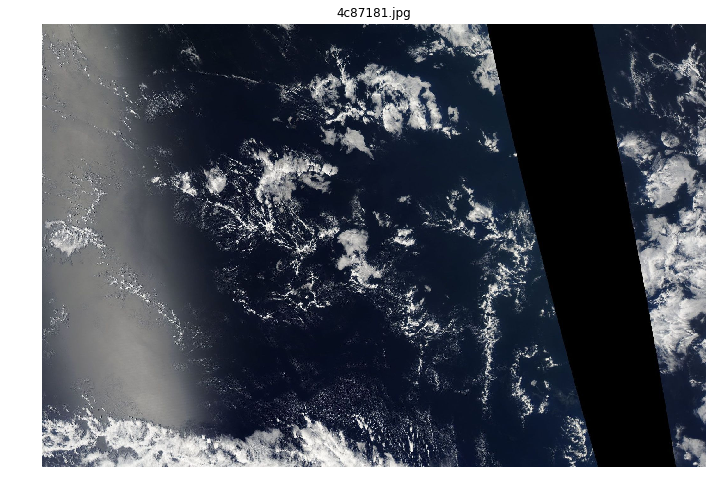

../../input/understanding_cloud_organization/test_images/c4fca1f.jpg


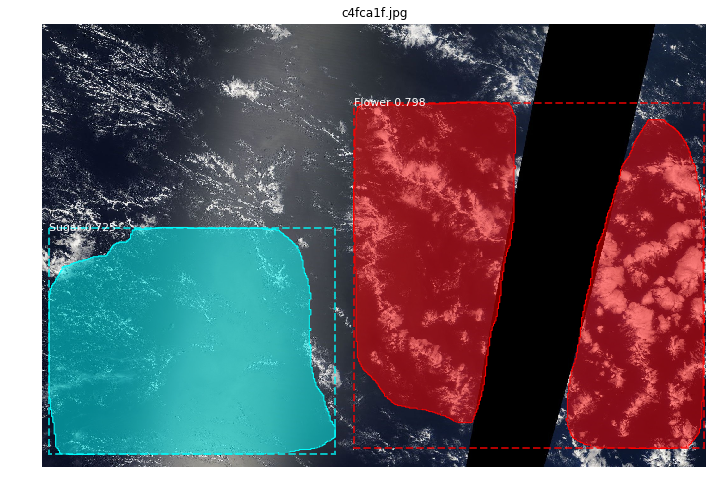

../../input/understanding_cloud_organization/test_images/04080dd.jpg


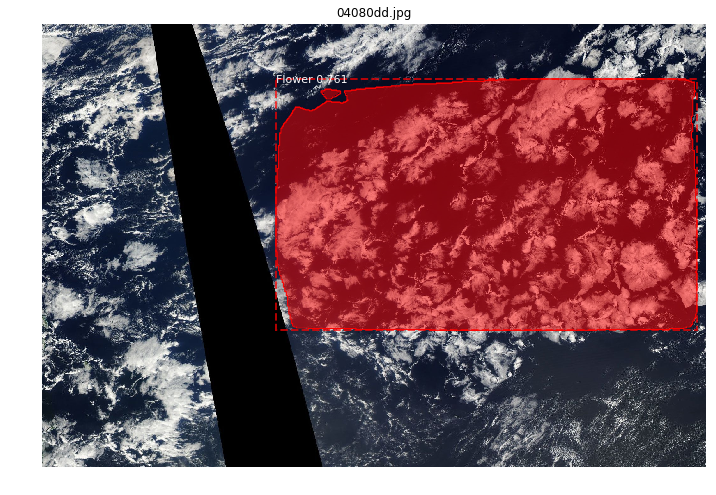

../../input/understanding_cloud_organization/test_images/02a1a4f.jpg


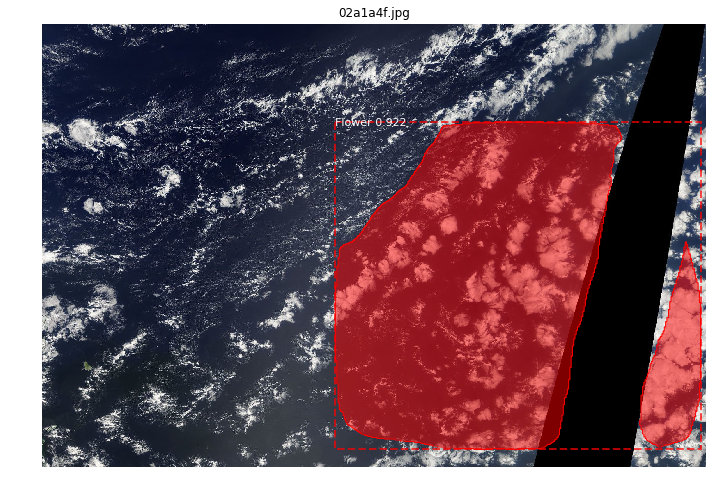

../../input/understanding_cloud_organization/test_images/c4fca1f.jpg


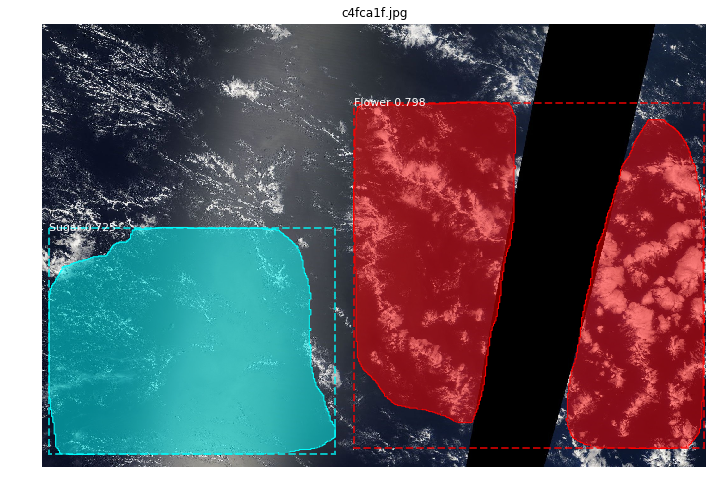

../../input/understanding_cloud_organization/test_images/e8db7b3.jpg


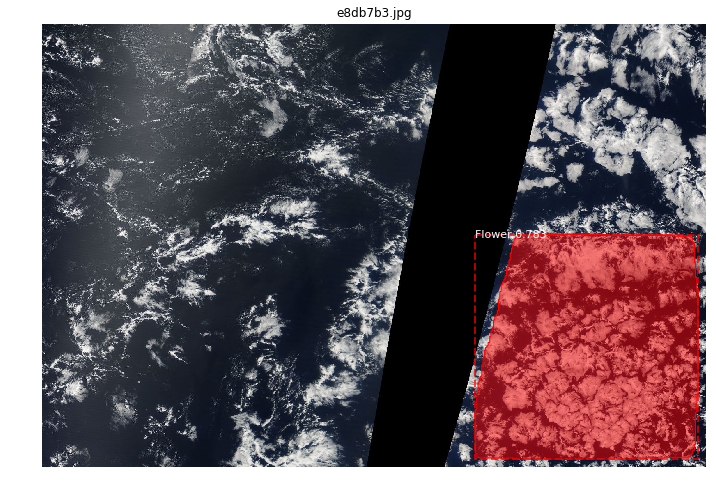

../../input/understanding_cloud_organization/test_images/4303d64.jpg


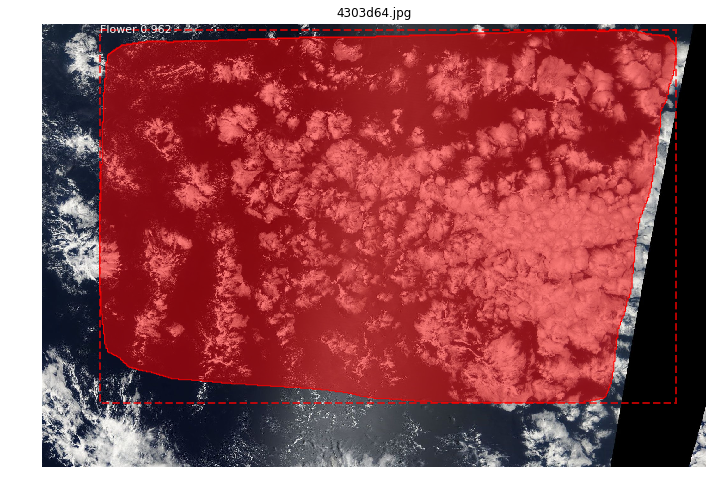

../../input/understanding_cloud_organization/test_images/76ff6b6.jpg

*** No instances to display *** 



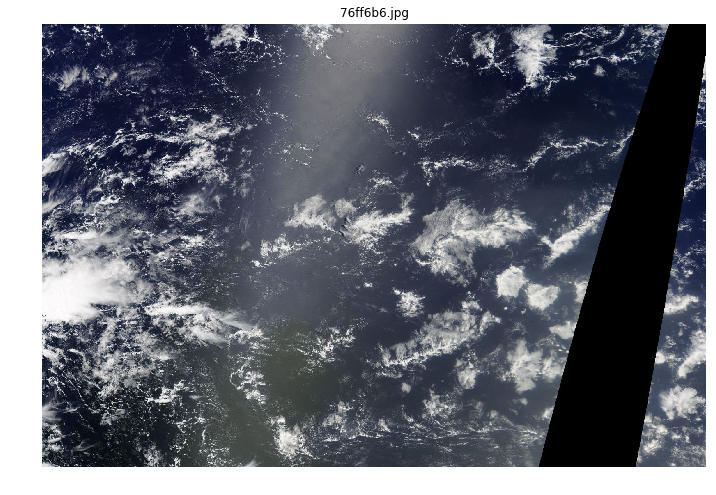

In [29]:
#COMMENTED OUT AS WE DON"T WANT TEST DF (just train DF for analysis)
#make predictions for each image.
for i in range(8):
    image_id = test_df.sample()["image_id"].values[0]
    image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(12, 12))

# FURTHER ANALYSISIS OF OUR RESULTS

In [30]:
# #create dataframe for train 
# train_df_results = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
# for idx,row in train_df.iterrows():
#     image_filename = row.Image_Label.split("_")[0]
#     train_df_results = train_df_results.append({"image_id": image_filename},ignore_index=True)
# # train_df_results = train_df_results.drop_duplicates() #if the imageid encoded pixels and the catagory id are the same drop them

In [31]:
# def rle_encoding(x):
#     dots = np.where(x.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return ' '.join([str(x) for x in run_lengths])

In [32]:
#bug fix if run out of order
# os.chdir('Mask_RCNN')
# os.getcwd()

In [33]:
# submission_df = train_df.copy() #temperary why is this missing some?
# submission_df["EncodedPixels"] = ""

# with tqdm(total=len(train_df)) as pbar:
#     for i,row in train_df_results.iterrows(): #test_df.iterrows():#
#         pbar.update(1)
#         image_id = row["image_id"]
#         image_path = str('../../input/understanding_cloud_organization/train_images/'+image_id) #changed to train
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         result = model.detect([resize_image(image_path)])
#         r = result[0]

#         if r['masks'].size > 0:
#             masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
#             for m in range(r['masks'].shape[-1]):
#                 masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
#                                             (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

#             y_scale = img.shape[0]/IMAGE_SIZE
#             x_scale = img.shape[1]/IMAGE_SIZE
#             rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
#             masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

#             #The following piece of code is creating rectangular masks from
#             # the ROIs instead of using the masks drawn by the MaskRCNN.
#             # It also removes any missing area from the imagery from the predicted masks.
#             # Everything is added directly to the submission dataframe.
#             rectangular_masks = []
#             mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
#             for roi, class_id in zip(rois, class_ids):
#                 rectangular_mask = np.zeros((512,512))
#                 rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
#                 img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
#                 cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
#                 kernel = np.ones((5,5),np.uint8)
#                 missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
#                 contour_mask = np.zeros(missing_data.shape)
#                 opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
#                 contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#                 if len(contours[0])>0:
#                     largest_contour = max(contours[0], key = cv2.contourArea)
#                     cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
#                     kernel = np.ones((5,5),np.uint8)
#                     opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
#                     fixed_mask = np.where(opening[:,:]==255,0,255)
#                     rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
#                 if mask_dict[category_list[class_id-1]]==[]:
#                     mask_dict[category_list[class_id-1]] = rectangular_mask
#                 else:
#                     previous_mask = mask_dict[category_list[class_id-1]].copy()
#                     #prevents a bug where the mask is in int64
#                     previous_mask = previous_mask.astype('float64')
#                     boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
#                     merged_mask = np.where(boolean_mask, 255, 0)
#                     mask_dict[category_list[class_id-1]] = merged_mask

            
#             #Going through the masks per category and create a md mask in RLE
#             for cloud_category in mask_dict.keys():
#                 if mask_dict[cloud_category]!=[]:
#                     #resizing for submission
#                     resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
#                     rle_str = rle_encoding(resized_mask)
#                     image_label = "{}_{}".format(image_id,cloud_category)
#                     submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
#         else:
#             masks, rois = r['masks'], r['rois']

In [34]:
# submission_df.to_csv("../../working/resultsTrainPredicted.csv",index=False)

In [35]:
# #identify JUST the validation set that we have (BROKEN)-leave this cell commented out
# training_percentage = 0.9

# training_set_size = int(training_percentage*len(submission_df)) #the data we used to train model
# # validation_set_size = int((1-training_percentage)*len(df)) #what remains
# print(training_set_size)
# print(submission_df[training_set_size:])

# validation_df = submission_df[training_set_size:]
# submission_df.to_csv("../../working/resultsValidation.csv",index=False)

# Submit predictions

In [36]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

Due to the rectangular shape of the groundtruth, I have decided to use the ROIs and not the masks given by the MaskRCNN. The regions in images where there are no data are removed from the ROIs before generating the RLE. More experimentation will be required. (REVISED BELOW)

In [37]:
#THIS IS MODIFIED FROM THE BELOW (commented out) version that uses the rectangular boxes instead of segmentation masks
submission_df = sample_df.copy()
submission_df["EncodedPixels"] = ""
with tqdm(total=len(test_df)) as pbar:
    for i,row in test_df.iterrows():
        pbar.update(1)
        image_id = row["image_id"]
        image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0: #there actually are regions detected in the image
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

            #The following piece of code is creating rectangular masks from
            # the ROIs instead of using the masks drawn by the MaskRCNN.
            # It also removes any missing area from the imagery from the predicted masks.
            # Everything is added directly to the submission dataframe.
            rectangular_masks = []
            mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
            index_mask = 0
            for boolean_mask, class_id in zip(masks, class_ids):######## broken
                boolean_mask_actual = r['masks'][:,:,index_mask] #fixing since for somereason boolean_mask dropped a dimension.
                index_mask += 1 #so next time we get new mask
#                 print(boolean_mask_actual.shape) #DEBUGGING (512,1)
                rectangular_mask = np.zeros((512,512))
                rectangular_mask[boolean_mask_actual==True] = 255 #set all areas where the mask are to 255 

                img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
                
                #######solid up until here
#                 cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]] #no?
                
#                 kernel = np.ones((5,5),np.uint8)
                  #this is going to set anyplace in the image where its 0 to 255 and anywhere else to 0
#                 missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8') 
#                 contour_mask = np.zeros(missing_data.shape)
#                 opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
#                 contours = cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                
#                 if len(contours[0])>0:
#                     largest_contour = max(contours[0], key = cv2.contourArea)
#                     cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
#                     kernel = np.ones((5,5),np.uint8)
#                     opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
#                     fixed_mask = np.where(opening[:,:]==255,0,255) #no?
#                     rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy() #no I don't belive so
                    
                if mask_dict[category_list[class_id-1]]==[]: #if no proposed mask alread exists??? (not sure why this would ever not be the case)
                    mask_dict[category_list[class_id-1]] = rectangular_mask #
                else:
                    previous_mask = mask_dict[category_list[class_id-1]].copy()
                    #prevents a bug where the mask is in int64
                    previous_mask = previous_mask.astype('float64')
                    boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask) #possibly want to remove this as overlaps exist in dataset
                    merged_mask = np.where(boolean_mask, 255, 0)
                    mask_dict[category_list[class_id-1]] = merged_mask

            
            #Going through the masks per category and create a md mask in RLE
            for cloud_category in mask_dict.keys():
                if mask_dict[cloud_category]!=[]:
                    #resizing for submission
                    resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
                    rle_str = rle_encoding(resized_mask)
                    image_label = "{}_{}".format(image_id,cloud_category)
                    submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
        else:
            masks, rois = r['masks'], r['rois']

100%|██████████| 3698/3698 [2:39:56<00:00,  2.60s/it]


In [38]:
# submission_df = sample_df.copy()
# submission_df["EncodedPixels"] = ""
# with tqdm(total=len(test_df)) as pbar:
#     for i,row in test_df.iterrows():
#         pbar.update(1)
#         image_id = row["image_id"]
#         image_path = str('../../input/understanding_cloud_organization/test_images/'+image_id)
#         img = cv2.imread(image_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#         result = model.detect([resize_image(image_path)])
#         r = result[0]

#         if r['masks'].size > 0:
#             masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
#             for m in range(r['masks'].shape[-1]):
#                 masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
#                                             (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

#             y_scale = img.shape[0]/IMAGE_SIZE
#             x_scale = img.shape[1]/IMAGE_SIZE
#             rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
#             masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

#             #The following piece of code is creating rectangular masks from
#             # the ROIs instead of using the masks drawn by the MaskRCNN.
#             # It also removes any missing area from the imagery from the predicted masks.
#             # Everything is added directly to the submission dataframe.
#             rectangular_masks = []
#             mask_dict = {"Fish":[],"Flower":[],"Gravel":[],"Sugar":[]}
#             for roi, class_id in zip(rois, class_ids):
#                 rectangular_mask = np.zeros((512,512))
#                 rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
#                 img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
#                 cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
#                 kernel = np.ones((5,5),np.uint8)
#                 missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
#                 contour_mask = np.zeros(missing_data.shape)
#                 opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
#                 contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#                 if len(contours[0])>0:
#                     largest_contour = max(contours[0], key = cv2.contourArea)
#                     cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
#                     kernel = np.ones((5,5),np.uint8)
#                     opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
#                     fixed_mask = np.where(opening[:,:]==255,0,255)
#                     rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
#                 if mask_dict[category_list[class_id-1]]==[]:
#                     mask_dict[category_list[class_id-1]] = rectangular_mask
#                 else:
#                     previous_mask = mask_dict[category_list[class_id-1]].copy()
#                     #prevents a bug where the mask is in int64
#                     previous_mask = previous_mask.astype('float64')
#                     boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
#                     merged_mask = np.where(boolean_mask, 255, 0)
#                     mask_dict[category_list[class_id-1]] = merged_mask

            
#             #Going through the masks per category and create a md mask in RLE
#             for cloud_category in mask_dict.keys():
#                 if mask_dict[cloud_category]!=[]:
#                     #resizing for submission
#                     resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
#                     rle_str = rle_encoding(resized_mask)
#                     image_label = "{}_{}".format(image_id,cloud_category)
#                     submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
#         else:
#             masks, rois = r['masks'], r['rois']

In [39]:
submission_df.query("EncodedPixels!=''").head()

Image_Label                                      EncodedPixels
2   002f507.jpg_Gravel  400 220 728 272 1070 293 1417 304 1765 307 211...
11   0038327.jpg_Sugar  4406 3 4419 8 4432 9 4442 2 4448 6 4455 2 4458...
13  004f759.jpg_Flower  92492 63 92830 92 93170 111 93519 112 93868 11...
18  005ba08.jpg_Gravel  26732 11 27060 50 27396 70 27700 12 27727 103 ...
20    006440a.jpg_Fish  26658 24 26974 63 27316 75 27664 78 28013 80 2...

In [40]:
submission_df.to_csv("../../working/submission.csv",index=False)